# Kaggle Competition 

In [42]:
import pandas as pd
import numpy as np
import joblib
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [43]:
val_df = pd.read_parquet("data/validate_data.parquet")

In [44]:
feature_cols = [f"feature_{idx:02d}" for idx in range(79)]+ [f"responder_{idx}_lag_1" for idx in range(9)]

#select target values
target_cols = ["responder_6"]

# select the weight values
weight_cols = ["weight"]

In [45]:
X_val = val_df[feature_cols]
y_val = val_df[target_cols]
w_val = val_df[weight_cols]

In [46]:
class MyModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dims, dropouts, lr, weight_decay):
        super().__init__()
        self.save_hyperparameters()
        layers = []
        in_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.BatchNorm1d(in_dim))
            if i > 0:
                layers.append(nn.SiLU())
            if i < len(dropouts):
                layers.append(nn.Dropout(dropouts[i]))
            layers.append(nn.Linear(in_dim, hidden_dim))
            # layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, 1))  # 输出层
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        self.lr = lr
        self.weight_decay = weight_decay
        self.validation_step_outputs = []
    
    def forward(self, x):
        return 5 * self.model(x).squeeze(-1)
    
    def training_step(self, batch):
        x, y, w = batch
        y_hat = self(x)
        y = y.view(-1)
        loss = F.mse_loss(y_hat, y, reduction='none') * w  #
        loss = loss.mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        return loss

    def validation_step(self, batch):
        x, y, w = batch
        y_hat = self(x)
        y = y.view(-1)
        loss = F.mse_loss(y_hat, y, reduction='none') * w
        loss = loss.mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.validation_step_outputs.append((y_hat, y, w))
        return loss

    # def on_validation_epoch_end(self):
    #     """Calculate validation WRMSE at the end of the epoch."""
    #     y = torch.cat([x[1] for x in self.validation_step_outputs]).cpu().numpy()
    #     if self.trainer.sanity_checking:
    #         prob = torch.cat([x[0] for x in self.validation_step_outputs]).cpu().numpy()
    #     else:
    #         prob = torch.cat([x[0] for x in self.validation_step_outputs]).cpu().numpy()
    #         weights = torch.cat([x[2] for x in self.validation_step_outputs]).cpu().numpy()
    #         # Ensure the shapes match by specifying the axis
    #         val_r_square = r2_val(y, prob, weights, axis=0)
    #         self.log("val_r_square", val_r_square, prog_bar=True, on_step=False, on_epoch=True)
    #     self.validation_step_outputs.clear()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5,
                                                               verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

    # def on_train_epoch_end(self):
    #     if self.trainer.sanity_checking:
    #         return
    #     epoch = self.trainer.current_epoch
    #     metrics = {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in self.trainer.logged_metrics.items()}
    #     formatted_metrics = {k: f"{v:.5f}" for k, v in metrics.items()}
    #     print(f"Epoch {epoch}: {formatted_metrics}")

    def save_model(self, path):
        """Save the model's state dictionary to the specified path."""
        torch.save(self.state_dict(), path)

In [47]:
model  = MyModel.load_from_checkpoint("lightning_logs/version_24/checkpoints/models/nn.model.ckpt")
model= model.to("cuda")
model.eval()

MyModel(
  (model): Sequential(
    (0): BatchNorm1d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=88, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SiLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SiLU()
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): Linear(in_features=256, out_features=1, bias=True)
    (11): Tanh()
  )
)

In [48]:
from sklearn.metrics import r2_score

In [49]:
with torch.no_grad():
  pred = model(torch.FloatTensor(X_val.values).to("cuda"))
pred = pred.cpu().detach().numpy()
r2 =  r2_score(y_val, pred, sample_weight= w_val)
print(f"R2 score: {r2:.6f}")

R2 score: 0.006905


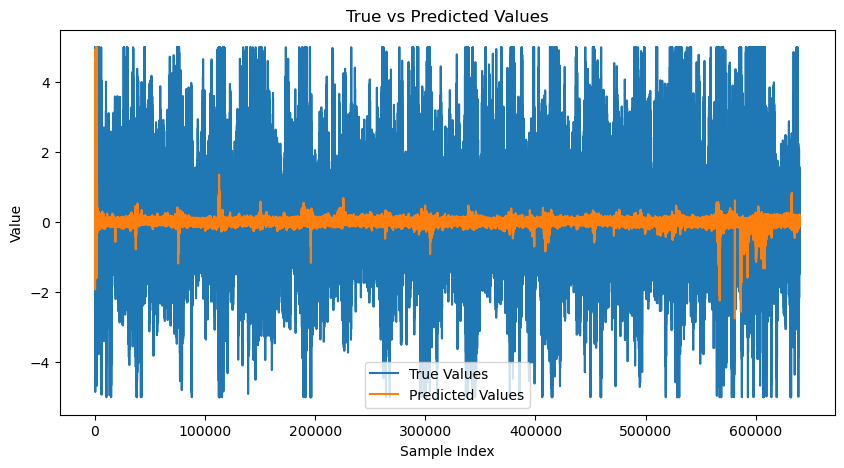

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(y_val.reset_index(drop =True), label='True Values')
plt.plot(pred, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()